# TFIDF document-level vectorization technique - Summary Jupyter Notebook

### Imports


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
import spacy
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WhitespaceTokenizer as w_tokenizer
import numpy
import string

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

### Read data

In [2]:
df = pd.read_csv('../../data/insurance_qna_dataset.csv',delimiter="\t")
df.head()
df.drop('Unnamed: 0',axis = 1)

,Question,Answer
0,What Happens When Term Life Insurance Is Paid ...,Actually term life insurance cannot be paid up...
1,What Happens When Term Life Insurance Is Paid ...,Term life insurance is never paid up. Assuming...
2,What Happens When Term Life Insurance Is Paid ...,Term Life Insurance does not have the option t...
3,What Does Renters Insurance Cover?,A renters insurance policy will typically prov...
4,What Does Renters Insurance Cover?,If you apartment was on fire and all your pers...
...,...,...
27989,What is,I'm not sure.\n
27990,Can I,I'm not sure.\n
27991,Which,I'm not sure.\n
27992,Does,I'm not sure.\n


In [3]:
df_test = pd.read_excel('../../data/testData.xlsx')
trueQuestions = df['Question'][df_test['ID']].reset_index()
trueQuestions = trueQuestions['Question']
df_test.head()

,ID,Question,Q'
0,20224,Does Homeowners Insurance Cover Pool Leaks?,Doe Homeowner Insurance Cover Pool Leak ?
1,20224,Does Homeowners Insurance Cover Pool Leaks?,Does Residents Insurance Cover Pool Leaks?
2,20224,Does Homeowners Insurance Cover Pool Leaks?,Do Pool Leaks Fall Under Homeowners Insurance?
3,8359,Does Usaa Offer Disability Insurance?,Doe Usaa Offer Disability Insurances ?
4,8359,Does Usaa Offer Disability Insurance?,Does Usaa Recommend Disability Insurance?


In [4]:
df.drop_duplicates('Question', inplace = True, ignore_index = True)

## Explore TF-IDF (term frequency - inverse document frequency) with different similarity metrics (cosine, manhattan, euclid) and determine which combination gives the best result.


In [5]:
def findBestDistanceMetric(x,y,yTrue, nBest = 100):
    performance = []
    corpus = x
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    testCorpus = y
    Y = vectorizer.transform(testCorpus)
    for distanceMetric in ('euclidean_distances','manhattan_distances','cosine_distances'):
        score = 0
        distance = eval(distanceMetric + '(Y,X)')
        for i in range(0, len(yTrue)):
            nInd = distance[i,:].argsort()[:nBest]
            nQue = corpus[nInd]
            realQ = yTrue[i]
            temp = 2 * nBest
            for k in range(0, nBest):
                if realQ == nQue[nInd[k]]:
                    temp = k
                    break
            #if temp > nBest:
            #    print('Pravo: ' + realQ)
            #    print('Q\': ' + testCorpus[i]) 
            score = score + temp
        print(distanceMetric + ': ' + str(score))
        performance.append(score)
    objects = ('euclidean_distances','manhattan_distances','cosine_distances')
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Error')
    plt.title('Error for different metrics')
    plt.show()     

euclidean_distances: 1996
manhattan_distances: 2079
cosine_distances: 1996


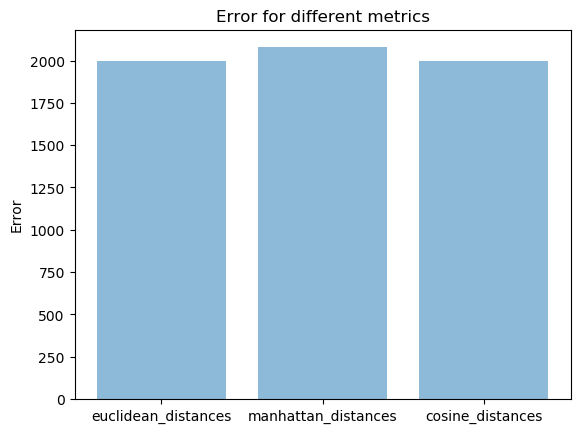

In [6]:
findBestDistanceMetric(df['Question'], df_test['Q\''], trueQuestions)

## As an addition to TF-IDF + best distance metric, add Lemmatization to the pipeline as a pre-processing step and evaluate how it affects model performance.

In [7]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/uros/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


In [9]:
dfLematization = df.copy()

In [10]:
dfLematization['Question'] = dfLematization['Question'].apply(lemmatize_text)
dfLematization['Question'] = dfLematization['Question'].str.join(' ')
dfLematization.head()

,Unnamed: 0,Question,Answer
0,0,What Happens When Term Life Insurance Is Paid Up?,Actually term life insurance cannot be paid up...
1,3,What Does Renters Insurance Cover?,A renters insurance policy will typically prov...
2,5,Does Owning A Pitbull Raise Homeowners Insurance?,Most insurance companies do not surcharge for ...
3,6,What Should You Look For In Long Term Care Ins...,Every product purchase has a value proposition...
4,7,Will Medicare Pay For Smoking Cessation?,Medicare will not pay for smoking cessation pr...


In [11]:
testDataLematization = df_test.copy()


In [12]:
testDataLematization['Q\''] = testDataLematization['Q\''].apply(lemmatize_text)
testDataLematization['Q\''] = testDataLematization['Q\''].str.join(' ')
testDataLematization.head()

,ID,Question,Q'
0,20224,Does Homeowners Insurance Cover Pool Leaks?,Doe Homeowner Insurance Cover Pool Leak ?
1,20224,Does Homeowners Insurance Cover Pool Leaks?,Does Residents Insurance Cover Pool Leaks?
2,20224,Does Homeowners Insurance Cover Pool Leaks?,Do Pool Leaks Fall Under Homeowners Insurance?
3,8359,Does Usaa Offer Disability Insurance?,Doe Usaa Offer Disability Insurances ?
4,8359,Does Usaa Offer Disability Insurance?,Does Usaa Recommend Disability Insurance?


In [13]:
trueQuestions_L = trueQuestions.apply(lemmatize_text)
trueQuestions_L = trueQuestions_L.str.join(' ')
print(trueQuestions_L)

0           Does Homeowners Insurance Cover Pool Leaks?
1           Does Homeowners Insurance Cover Pool Leaks?
2           Does Homeowners Insurance Cover Pool Leaks?
3                 Does Usaa Offer Disability Insurance?
4                 Does Usaa Offer Disability Insurance?
                            ...                        
58    What Type Of Drug Test Is Used For Life Insura...
59    What Type Of Drug Test Is Used For Life Insura...
60       Can You Get Life Insurance On Someone In Jail?
61       Can You Get Life Insurance On Someone In Jail?
62       Can You Get Life Insurance On Someone In Jail?
Name: Question, Length: 63, dtype: object


euclidean_distances: 2185
manhattan_distances: 2268
cosine_distances: 2185


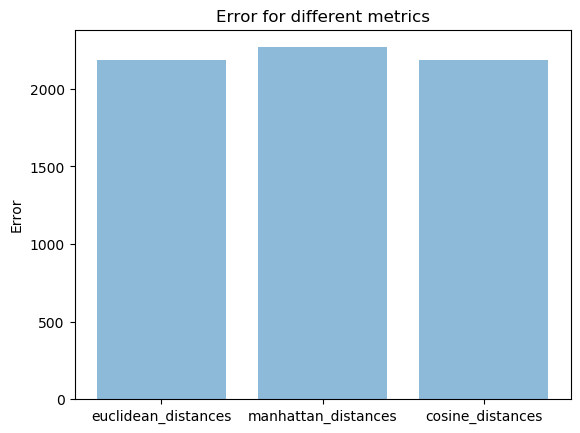

In [14]:
findBestDistanceMetric(dfLematization['Question'], testDataLematization['Q\''], trueQuestions_L)

## As an addition to TF-IDF + best distance metric, add Stemming to the pipeline as a pre-processing step and evaluate how it affects model performance.

In [15]:
englishStemmer=SnowballStemmer("english") 
def stem_text(text):
    return [englishStemmer.stem(w) for w in w_tokenizer.tokenize(text)]

In [16]:
dfStem = df.copy()

In [17]:
dfStem.head()

,Unnamed: 0,Question,Answer
0,0,What Happens When Term Life Insurance Is Paid ...,Actually term life insurance cannot be paid up...
1,3,What Does Renters Insurance Cover?,A renters insurance policy will typically prov...
2,5,Does Owning A Pitbull Raise Homeowners Insuran...,Most insurance companies do not surcharge for ...
3,6,What Should You Look For In Long Term Care Ins...,Every product purchase has a value proposition...
4,7,Will Medicare Pay For Smoking Cessation?,Medicare will not pay for smoking cessation pr...


In [18]:
dfStem['Question'] = dfStem['Question'].apply(stem_text)

In [19]:
dfStem.head()

,Unnamed: 0,Question,Answer
0,0,"[what, happen, when, term, life, insur, is, pa...",Actually term life insurance cannot be paid up...
1,3,"[what, doe, renter, insur, cover?]",A renters insurance policy will typically prov...
2,5,"[doe, own, a, pitbul, rais, homeown, insurance?]",Most insurance companies do not surcharge for ...
3,6,"[what, should, you, look, for, in, long, term,...",Every product purchase has a value proposition...
4,7,"[will, medicar, pay, for, smoke, cessation?]",Medicare will not pay for smoking cessation pr...


In [20]:
dfStem['Question'] = dfStem['Question'].str.join(' ')

In [21]:
dfStem.head()

,Unnamed: 0,Question,Answer
0,0,what happen when term life insur is paid up?,Actually term life insurance cannot be paid up...
1,3,what doe renter insur cover?,A renters insurance policy will typically prov...
2,5,doe own a pitbul rais homeown insurance?,Most insurance companies do not surcharge for ...
3,6,what should you look for in long term care ins...,Every product purchase has a value proposition...
4,7,will medicar pay for smoke cessation?,Medicare will not pay for smoking cessation pr...


In [22]:
testDataStem = df_test.copy()

In [23]:
testDataStem['Q\''] = testDataStem['Q\''].apply(stem_text)

In [24]:
testDataStem['Q\''] = testDataStem['Q\''].str.join(' ')

In [25]:
trueQuestions_S = trueQuestions.apply(stem_text)
trueQuestions_S = trueQuestions_S.str.join(' ')
print(trueQuestions_S)

0                   doe homeown insur cover pool leaks?
1                   doe homeown insur cover pool leaks?
2                   doe homeown insur cover pool leaks?
3                      doe usaa offer disabl insurance?
4                      doe usaa offer disabl insurance?
                            ...                        
58    what type of drug test is use for life insurance?
59    what type of drug test is use for life insurance?
60            can you get life insur on someon in jail?
61            can you get life insur on someon in jail?
62            can you get life insur on someon in jail?
Name: Question, Length: 63, dtype: object


euclidean_distances: 2069
manhattan_distances: 2105
cosine_distances: 2070


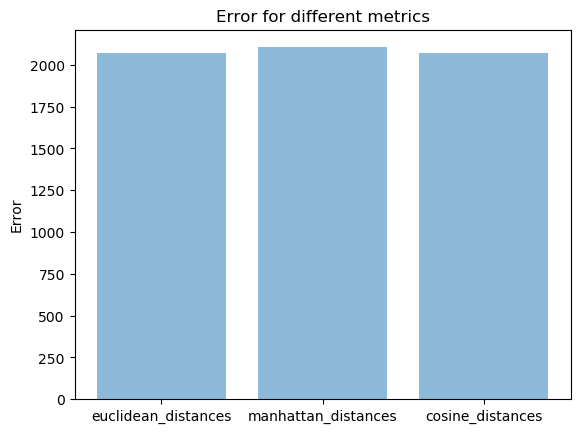

In [26]:
findBestDistanceMetric(dfStem['Question'], testDataStem['Q\''], trueQuestions_S)

 ## Experiment with n-grams as an extension of unigrams for word representation.



In [27]:
def findBestDistanceMetricNgram(x,y,yTrue, nBest = 100):
    performance = []
    corpus = x
    for ngram in [(1,1),(1,2), (2,2), (1,3), (2,3)]:
        print(ngram)
        vectorizer = TfidfVectorizer(ngram_range = ngram)
        X = vectorizer.fit_transform(corpus)
        testCorpus = y
        Y = vectorizer.transform(testCorpus)
        for distanceMetric in ('euclidean_distances','manhattan_distances','cosine_distances'):
            score = 0
            distance = eval(distanceMetric + '(Y,X)')
            for i in range(0, len(yTrue)):
                nInd = distance[i,:].argsort()[:nBest]
                nQue = corpus[nInd]
                realQ = yTrue[i]
                temp = 2 * nBest
                for k in range(0, nBest):
                    if realQ == nQue[nInd[k]]:
                        temp = k
                        break
                #if temp > nBest:
                #    print('Pravo: ' + realQ)
                #    print('Q\': ' + testCorpus[i]) 
                score = score + temp
            print(distanceMetric + ': ' + str(score))
            performance.append(score)

In [28]:
findBestDistanceMetricNgram(df['Question'], df_test['Q\''], trueQuestions)

(1, 1)
euclidean_distances: 1996
manhattan_distances: 2079
cosine_distances: 1996
(1, 2)
euclidean_distances: 2265
manhattan_distances: 2610
cosine_distances: 2265
(2, 2)
euclidean_distances: 3475
manhattan_distances: 3764
cosine_distances: 3309
(1, 3)
euclidean_distances: 2328
manhattan_distances: 2874
cosine_distances: 2328
(2, 3)
euclidean_distances: 3522
manhattan_distances: 5126
cosine_distances: 3321


## Evaluate how pairwise cosine or Unsupervised Nearest Neighbor (with KD-TREE or BALL-TREE) affect execution times, compared to sequential execution with for-loop.

In [29]:
yTrue = trueQuestions
corpus = df['Question']
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
testCorpus = df_test['Q\'']
nBest = 100

## Pairwise


In [30]:
%%time
Y = vectorizer.transform(testCorpus)
score = 0
distance = cosine_distances(Y,X)
for i in range(0, len(yTrue)):
    nInd = distance[i,:].argsort()[:nBest]
    nQue = corpus[nInd]
    realQ = yTrue[i]
    temp = 2 * nBest
    for k in range(0, nBest):
        if realQ == nQue[nInd[k]]:
            temp = k
            break
    score = score + temp

CPU times: user 102 ms, sys: 0 ns, total: 102 ms
Wall time: 101 ms
